In [1]:
%matplotlib inline

# ATAC-seq study power analysis

We'll review the fundamental properties of ATAC-seq depth and variation distributions for each regulatory element quantified in several projects on primary PBMC samples in the Bock lab.

The concept and statistical metrics are based on the report by Hart et al, Calculating Sample Size Estimates for RNA Sequencing Data, JOURNAL OF COMPUTATIONAL BIOLOGY, 2013 for RNA-seq data.

In [2]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Set settings
sns.set(context="paper", style="white", palette="colorblind", color_codes=True)
matplotlib.rcParams["svg.fonttype"] = "none"
matplotlib.rc('text', usetex=False)

Let's start by reading in the matrices for 4 projects and recover two vectors for each: average raw read coverage per regulatory element and the coefficient of variation (std / mean).

In [4]:
projects = [
    ("cll-chromatin", "~/projects/cll-chromatin/data_submission/cll_peaks.raw_coverage.tsv"),
    ("cll-ibrutinib", "~/projects/cll-ibrutinib/results/cll-ibrutinib_CLL_peaks.raw_coverage.csv"),
    ("cll-time_course", "~/projects/cll-time_course/results/cll-time_course_peaks.raw_coverage.csv"),
    ("cll-timetotreat", "~/projects/cll-timetotreat/results/cll-timetotreat_peaks.raw_coverage.csv")]

In [5]:
covs = dict()
cvs = dict()
for (project, coverage) in projects:
    print(project)

    cov = pd.read_table(coverage, index_col=0, sep="," if coverage.endswith("csv") else "\t")
    if 'chrom' in cov.columns:
        cov = cov.reset_index()
        cov['index'] = cov['chrom'] + ":" + cov['start'].astype(str) + "-" + cov['end'].astype(str)
        cov = cov.set_index("index")
    cov = cov.loc[:, cov.columns.str.contains("ATAC")]

    # Get average coverage in raw read counts per regulatory element
    covs[project] = cov.mean(axis=1)
    # Get coeficient of variation per regulatory element
    cvs[project] = cov.std(axis=1) / cov.mean(axis=1)

cll-chromatin
cll-ibrutinib
cll-time_course
cll-timetotreat


Let's now plot the distribution of raw read coverages for each project.
We will use various scales due to the exponential nature of NGS data but also because the emphasis is on comparing various projects.

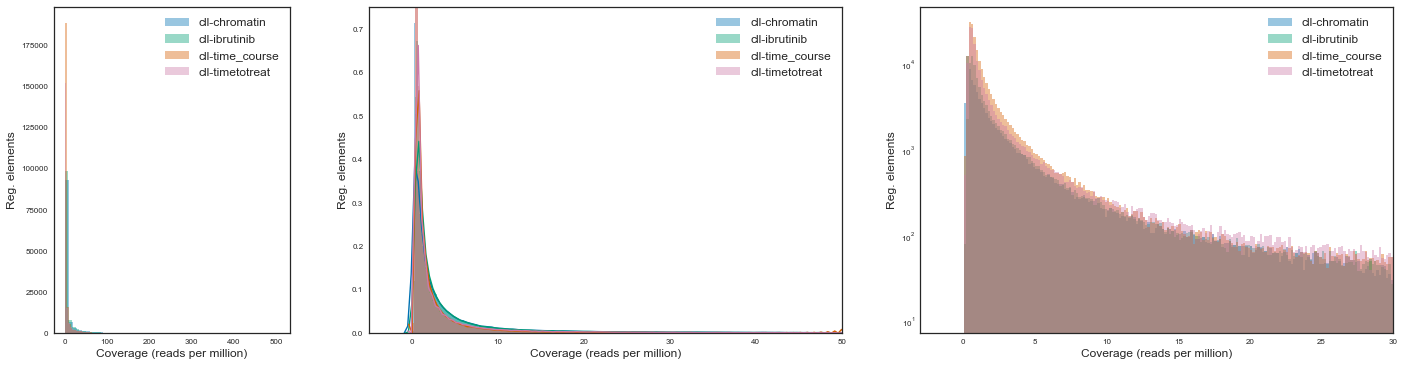

In [10]:
# Plot coverage for each project
fig, axis = plt.subplots(1, 3, figsize=(8 * 3, 6), gridspec_kw={"width_ratios": (0.2, 0.4, 0.4)})
for project, _ in projects:
    cov = covs[project].sort_values()
    rpm = (cov / cov.sum()) * 1e6
    sns.distplot(rpm, kde=False, ax=axis[0], label=project)
    sns.distplot(rpm[rpm < 50], kde=True, bins=300, ax=axis[1], label=project)
    sns.distplot(rpm[rpm < 50], kde=False, bins=300, ax=axis[2], label=project)
for ax in axis:
    ax.set_xlabel("Coverage (reads per million)", fontsize=12)
    ax.set_ylabel("Reg. elements", fontsize=12)
    ax.legend(fontsize=12)
axis[1].set_xlim((-5, 50))
axis[2].set_xlim((-3, 30))
axis[2].set_yscale("log")
fig.savefig("atac-seq_power_analysis.coverage_distribution.svg", bbox_inches="tight", dpi=300)

We see that across projects the type and shape of the distribution associated with read counts are extremely similar.

Now we will assess the level of (mostly) biological variation in the datasets. Since there is a relationship between technical variation and the mean depth of coverage in a certain regulatory element, the coefficient of variation allows us to phase this effect by dividing standard deviation by the mean coverage of each regulatory element.

Let's observe these distributions for the various projects:

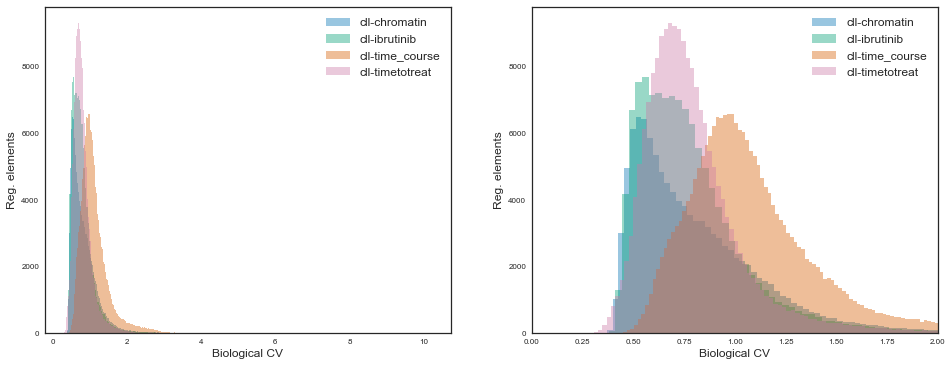

In [8]:
# Plot CVs for each project
fig, axis = plt.subplots(1, 2, figsize=(8 * 2, 6))
for project, _ in projects:
    cv = cvs[project].sort_values()
    sns.distplot(cv, kde=False, bins=300, ax=axis[0], label=project)
    sns.distplot(cv, kde=False, bins=300, ax=axis[1], label=project)
for ax in axis:
    ax.set_xlabel("Biological CV", fontsize=12)
    ax.set_ylabel("Reg. elements", fontsize=12)
    ax.legend(fontsize=12)
axis[1].set_xlim((0, 2))
fig.savefig("atac-seq_power_analysis.CV_distribution.svg", bbox_inches="tight", dpi=300)

While for all projects the distributions are some sort of gamma distribution, the the shape and scale parameters vary quite considerably.

The "cll-time_course" project shows markedly more variation than others, presumably because it is the only one where there are 6 pure (FACS) sorted cell types. On the other end, the "cll-chromatin" project shows the least amount of global variation, maybe because it focused on a single cell type with generally high purity. The other two projects contain either sorted CLL cells jointly with mixtures of PBMCs which are generally enriched for CLL cells, so also an intermideate between the extremes regarding cell type purity.

Let's also plot this in a cumulative manner for easier comparability, like Hart et al, figure 2:

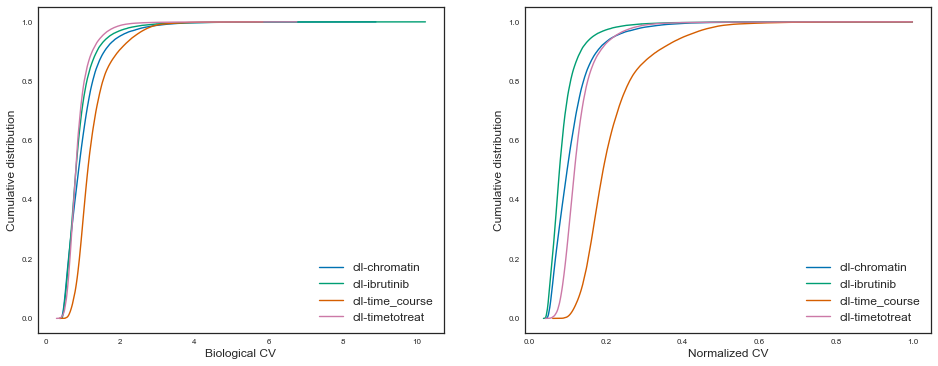

In [87]:
# Plot cumulative CVs for each project

fig, axis = plt.subplots(1, 2, figsize=(8 * 2, 6))
for project, _ in projects:
    cv = cvs[project].sort_values(ascending=True)
    axis[0].plot(cv, cv.cumsum() / cv.sum(), label=project)
    axis[1].plot(cv / cv.max(), cv.cumsum() / cv.sum(), label=project)
axis[0].set_xlabel("Biological CV", fontsize=12)
axis[1].set_xlabel("Normalized CV", fontsize=12)
for ax in axis:
    ax.set_ylabel("Cumulative distribution", fontsize=12)
# axis.set_title("Coeficient of variation for CLL ATAC-seq projects")
axis[0].legend(fontsize=12)
axis[1].legend(fontsize=12)
fig.savefig("atac-seq_power_analysis.cumulative_CV.svg", bbox_inches="tight", dpi=300)

Having measured and investigated the technical and parameters of ATAC-seq experiments, we can now start to infer what is the sample size needed to discover differential regulatory elements between sample groups given some level of confidence, effect size and power.

We will use the RNASeqPower R library by the same authors which implements a formula for the number of samples given the above parameters plus the technical ones such as the coefficient of variation and depth of coverage for each regulatory element.

For simplicity we will focus on a particular project which had the highest sample purity.

In [37]:
# Import the RNASeqPower R library
import rpy2
import rpy2.robjects as robjects
import rpy2.robjects.numpy2ri
rpy2.robjects.numpy2ri.activate()
robjects.r('require("RNASeqPower")')
rnapower = robjects.r('rnapower')

In [81]:
# Let's get the range of coverage and CV of a specific project

project = "cll-chromatin"
print(covs[project].describe())
print(cvs[project].describe())

count    111971.000000
mean         59.708063
std         154.245453
min           0.215909
25%           3.965909
50%          11.272727
75%          37.227273
max        3390.352273
dtype: float64
count    111971.000000
mean          0.829191
std           0.377015
min           0.369232
25%           0.567725
50%           0.732309
75%           0.981739
max           8.895140
dtype: float64


We will through a linear range of values of depth and variation observed in the study to estimate the number of samples, while at the same time also getting predictions for various levels of effect sizes and power. The significance level will always be 0.05.

In [83]:
effects = (1.25, 1.5, 2.0)
powers = (0.8, 0.9)
alpha = 0.05
quantiles = (0.1, 0.9)
bins = 100

depth_range = np.linspace(covs[project].quantile(quantiles[0]), covs[project].quantile(quantiles[1]), bins)
cv_range = np.linspace(cvs[project].quantile(quantiles[0]), cvs[project].quantile(quantiles[1]), bins)

res = pd.DataFrame()
for depth in depth_range:
    for cv in cv_range:
        p = pd.DataFrame(
            np.array(rnapower(depth=depth, cv=cv,
                 effect=robjects.vectors.FloatVector(effects),
                 alpha=alpha,
                 power=robjects.vectors.FloatVector(powers))),
            index=effects, columns=powers)
        p['depth'] = depth
        p['cv'] = cv
        res = res.append(p)

In [84]:
res.index.name = "effect"
res = pd.melt(res.reset_index(), id_vars=['effect', 'depth', 'cv'], var_name="power")
res.to_csv("atac-seq_power_analysis.sample_estimation.csv", index=False)
res.head()

,effect,depth,cv,power,value
0,1.25,1.965909,0.493028,0.8,236.995786
1,1.50,1.965909,0.493028,0.8,71.779814
2,2.00,1.965909,0.493028,0.8,24.561698
3,1.25,1.965909,0.500749,0.8,239.414878
4,1.50,1.965909,0.500749,0.8,72.512494


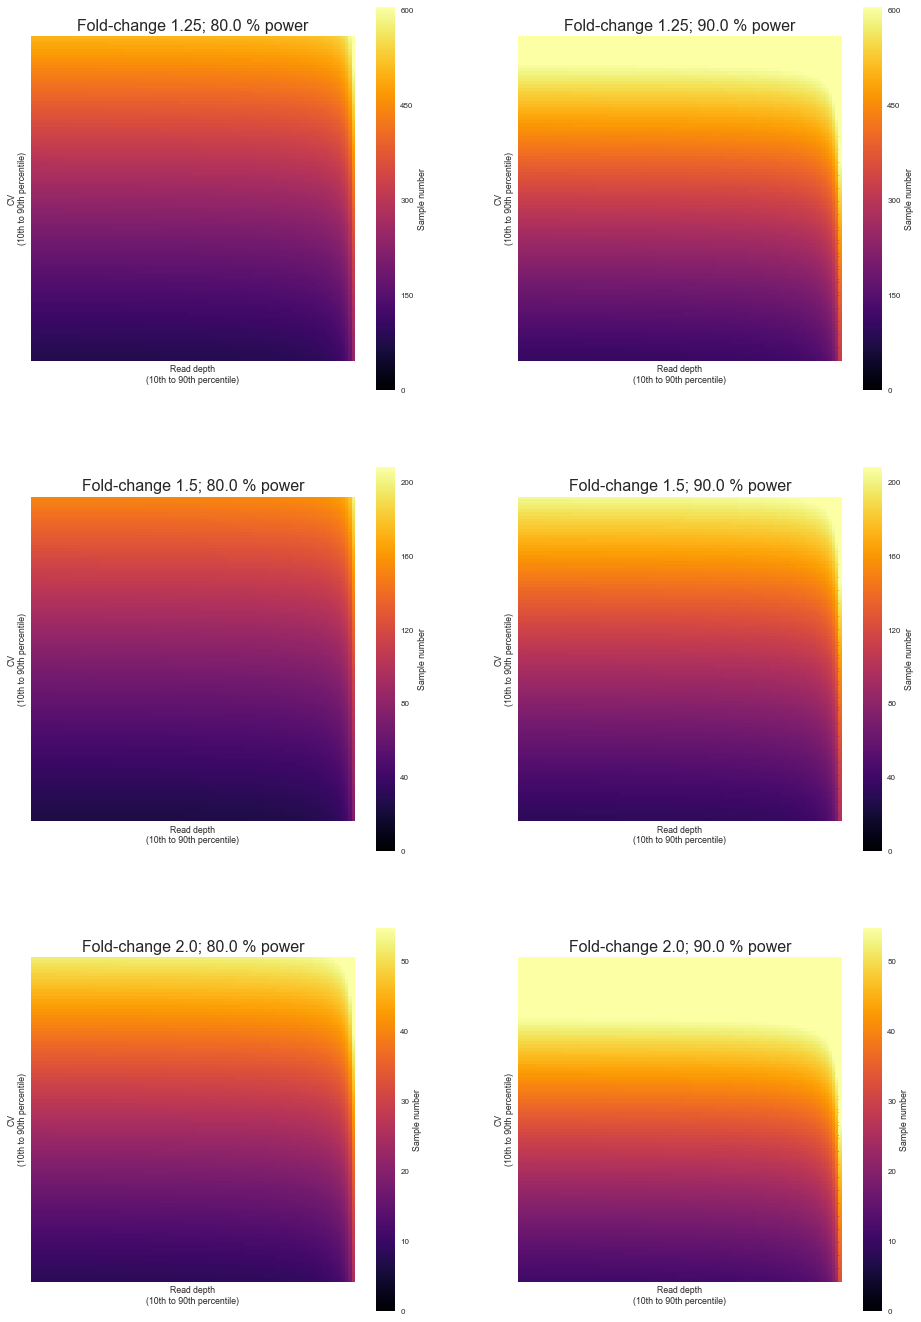

In [88]:
fig, axis = plt.subplots(len(effects), len(powers), figsize=(len(powers) * 8, 8 * len(effects)))
for i, effect in enumerate(effects):
    for j, power in enumerate(powers):
        p = pd.pivot_table(res[(res['power'] == power) & (res['effect'] == effect)], index='cv', columns='depth', values="value")
        p = p.sort_index(axis=0, ascending=False)
        p = p.sort_index(axis=1, ascending=False)
        sns.heatmap(
            p, xticklabels=False, yticklabels=False,
            cmap="inferno", vmin=0, vmax=3000 ** (1. / effect), robust=True, square=True, rasterized=True, cbar_kws={"label": "Sample number"},
            ax=axis[i, j])
        axis[i, j].set_title("Fold-change {}; {} % power".format(effect, power * 100), fontsize=16)
        axis[i, j].set_ylabel("CV\n(10th to 90th percentile)")
        axis[i, j].set_xlabel("Read depth\n(10th to 90th percentile)")
        axis[i, j].set_xticklabels(ax.get_xticklabels(), rotation=90)
        axis[i, j].set_yticklabels(ax.get_yticklabels(), rotation=0)
fig.savefig("atac-seq_power_analysis.sample_size.heatmaps.svg", bbox_inches="tight", dpi=300)

In [94]:
# export CV and depth for project
project = "cll-chromatin"
covs[project].to_frame(name="mean_depth").join(cvs[project].to_frame(name="cv")).to_csv(
    "atac-seq_power_analysis.metrics.csv")

In [ ]:
from zipfile import ZipFile